To start, we'll develop a collection of data points that appear random, but that fit a known linear equation 𝑦=2𝑥+1

### Load Libraries

In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

### Create a column matrix of X values
We can create tensors right away rather than convert from NumPy arrays.

In [4]:
X = torch.linspace(1, 50, 50).reshape(-1, 1)
# Equivalent to
X = torch.unsqueeze(torch.linspace(1,50,50), dim=1)
#X

### Create a "random" array of error values
We want 50 random integer values that collectively cancel each other out.

In [5]:
torch.manual_seed(71)
e = torch.randint(-8, 9, (50, 1), dtype=torch.float)
print(e.sum())

tensor(0.)


### Create a column matrix of y values
Here we'll set our own parameters of $\mathrm {weight} = 2,\; \mathrm {bias} = 1$, plus the error amount.<br><strong><tt>y</tt></strong> will have the same shape as <strong><tt>X</tt></strong> and <strong><tt>e</tt></strong>

In [8]:
y = 2*X + 1 + e
print(y.shape)

torch.Size([50, 1])


### Plot the results
We have to convert tensors to NumPy arrays just for plotting.

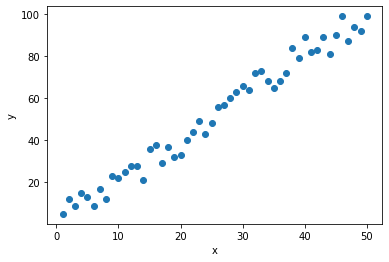

In [9]:
plt.scatter(X.numpy(), y.numpy())
plt.ylabel('y')
plt.xlabel('x');

Note that when we created tensor $X$, we did <em>not</em> pass <tt>requires_grad=True</tt>. This means that $y$ doesn't have a gradient function, and <tt>y.backward()</tt> won't work. Since PyTorch is not tracking operations, it doesn't know the relationship between $X$ and $y$.

### Simple linear model
As a quick demonstration we'll show how the built-in <tt>nn.Linear()</tt> model preselects weight and bias values at random.

In [10]:
torch.manual_seed(59)

model = nn.Linear(in_features=1, out_features=1)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[0.1060]], requires_grad=True)
Parameter containing:
tensor([0.9638], requires_grad=True)


Without seeing any data, the model sets a random weight of 0.1060 and a bias of 0.9638.

## Model classes
PyTorch lets us define models as object classes that can store multiple model layers. In upcoming sections we'll set up several neural network layers, and determine how each layer should perform its forward pass to the next layer. For now, though, we only need a single <tt>linear</tt> layer.

In [11]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

<div class="alert alert-info"><strong>NOTE:</strong> The "Linear" model layer used here doesn't really refer to linear regression. Instead, it describes the type of neural network layer employed. Linear layers are also called "fully connected" or "dense" layers. Going forward our models may contain linear layers, convolutional layers, and more.</div>

When <tt>Model</tt> is instantiated, we need to pass in the size (dimensions) of the incoming and outgoing features. For our purposes we'll use (1,1).<br>As above, we can see the initial hyperparameters.

In [12]:
torch.manual_seed(59)
model = Model(1, 1)
print(model)
print(f'model weights :- {model.linear.weight.item()}')
print(f'model bias :- {model.linear.bias.item()}')

Model(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
model weights :- 0.10597813129425049
model bias :- 0.9637961387634277


In [15]:
for name, parameters in model.named_parameters():
    print(name, "\t", parameters.item())

linear.weight 	 0.10597813129425049
linear.bias 	 0.9637961387634277


<div class="alert alert-info"><strong>NOTE:</strong> In the above example we had our Model class accept arguments for the number of input and output features.<br>For simplicity we can hardcode them into the Model:
         
<tt><font color=black>
class Model(torch.nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.linear = Linear(1,1)<br><br>
model = Model()
</font></tt><br><br>

Alternatively we can use default arguments:

<tt><font color=black>
class Model(torch.nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, in_dim=1, out_dim=1):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.linear = Linear(in_dim,out_dim)<br><br>
model = Model()<br>
<em>\# or</em><br>
model = Model(i,o)</font></tt>
</div>

In [17]:
x = torch.tensor([2.0])
print(model.forward(x))   # equivalent to print(model(x))

tensor([1.1758], grad_fn=<AddBackward0>)


which is confirmed with $f(x) = (0.1060)(2.0)+(0.9638) = 1.1758$

### Plot the initial model
We can plot the untrained model against our dataset to get an idea of our starting point

In [18]:
x1 = np.array([X.min(),X.max()])
print(x1)

[ 1. 50.]


In [20]:
w1, b1 = model.linear.weight.item(), model.linear.bias.item()
print(f'Initial weight: {w1:.8f}, Initial bias: {b1:.8f}')
print()

y1 = x1*w1 + b1
print(y1)

Initial weight: 0.10597813, Initial bias: 0.96379614

[1.0697743 6.2627025]


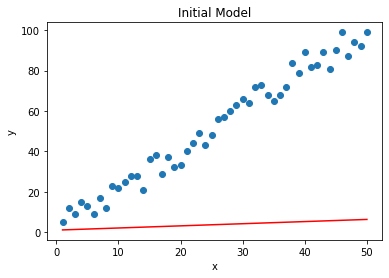

In [21]:
plt.scatter(X.numpy(), y.numpy())
plt.plot(x1,y1,'r')
plt.title('Initial Model')
plt.ylabel('y')
plt.xlabel('x');

## Set the loss function
We could write our own function to apply a Mean Squared Error (MSE) that follows<br>

$\begin{split}MSE &= \frac {1} {n} \sum_{i=1}^n {(y_i - \hat y_i)}^2 \\
&= \frac {1} {n} \sum_{i=1}^n {(y_i - (wx_i + b))}^2\end{split}$<br>

Fortunately PyTorch has it built in.<br>
<em>By convention, you'll see the variable name "criterion" used, but feel free to use something like "linear_loss_func" if that's clearer.</em>

In [23]:
criterion = nn.MSELoss()

In [24]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

### Train the model

In [25]:
epochs = 50
losses = []

for i in range(epochs):
    #i+=1
    y_pred = model.forward(X)
    loss = criterion(y_pred, y)
    losses.append(loss)
    print(f'epoch: {i:2}  loss: {loss.item():10.8f}  weight: {model.linear.weight.item():10.8f}  \
bias: {model.linear.bias.item():10.8f}') 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  0  loss: 3057.21679688  weight: 0.10597813  bias: 0.96379614
epoch:  1  loss: 1588.53100586  weight: 3.33490038  bias: 1.06046367
epoch:  2  loss: 830.30010986  weight: 1.01483274  bias: 0.99226278
epoch:  3  loss: 438.85241699  weight: 2.68179965  bias: 1.04252183
epoch:  4  loss: 236.76152039  weight: 1.48402119  bias: 1.00766504
epoch:  5  loss: 132.42912292  weight: 2.34460592  bias: 1.03396463
epoch:  6  loss: 78.56572723  weight: 1.72622538  bias: 1.01632178
epoch:  7  loss: 50.75775909  weight: 2.17050409  bias: 1.03025162
epoch:  8  loss: 36.40123367  weight: 1.85124576  bias: 1.02149546
epoch:  9  loss: 28.98922729  weight: 2.08060074  bias: 1.02903891
epoch: 10  loss: 25.16238213  weight: 1.91576838  bias: 1.02487016
epoch: 11  loss: 23.18647385  weight: 2.03416562  bias: 1.02911627
epoch: 12  loss: 22.16612816  weight: 1.94905841  bias: 1.02731562
epoch: 13  loss: 21.63911057  weight: 2.01017213  bias: 1.02985907
epoch: 14  loss: 21.36677170  weight: 1.96622372  bias

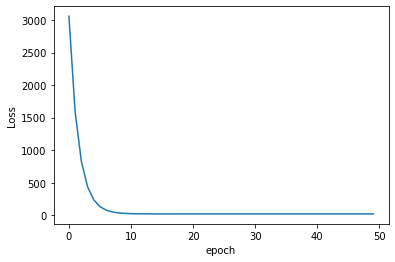

In [27]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

In [28]:
w1,b1 = model.linear.weight.item(), model.linear.bias.item()
print(f'Current weight: {w1:.8f}, Current bias: {b1:.8f}')
print()

y1 = x1*w1 + b1
print(x1)
print(y1)

Current weight: 1.98381913, Current bias: 1.05575156

[ 1. 50.]
[  3.0395708 100.246704 ]


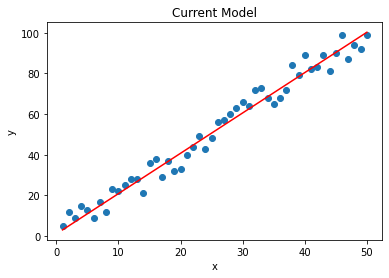

In [29]:
plt.scatter(X.numpy(), y.numpy())
plt.plot(x1,y1,'r')
plt.title('Current Model')
plt.ylabel('y')
plt.xlabel('x');